# ImageCLEF Medical Caption Task 2019

The [Image CLEF 2019 Concept Detection Task](https://www.imageclef.org/2019/medical/caption/) is a large-scale multi-label classification task aiming to identify medical terms (concepts) in radiology images. Implement a system to classify a medical image based on several abnormalities represented by [Unified Medical Language System (UMLS)](https://www.nlm.nih.gov/research/umls/index.html) concept IDs.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import os
import time
import cv2
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# Disclaimer before moving to the project

The different parts of the analysis of this project and the different models that were developed were ran either in different jupyter notebooks or after restarting the python kernel because the ram on the PC that this project was being written was overflowing.

Thus, I was unable to run everything in this notebook in a single run and therefore any attempt to do so may result in unforseeable results.

I did my best to make it work as well as possible, but, surely, errors will arise if you try to run everything at once.

I urge you to run sections and models seperately in order to ensure that you get the same results as the ones shown here.

# Getting the Data

First, we need to put the data in the right folders so that we can help ourselves in our analysis.

In [2]:
string_concepts = 'ImageCLEF2019/string_concepts.csv'
train_concepts = 'ImageCLEF2019/train_concepts.csv'
val_concepts = 'ImageCLEF2019/val_concepts.csv'

str_con = pd.read_csv(string_concepts, sep='\t', header=None)
str_con.rename(columns={0: 'CUI', 1: 'UMLS Term'}, inplace=True)
train_con = pd.read_csv(train_concepts)
val_con = pd.read_csv(val_concepts)
train_set = 'ImageCLEF2019/train/training-set/'
test_set = 'ImageCLEF2019/test/'
val_set = 'ImageCLEF2019/validation/validation-set/'

In [3]:
names = list(str_con['CUI'])

# Data Exploration

Let's see what is in our dataset so that we can get a better idea with what we are dealing with.

* First, we will plot some images to see what kind of data we have and we will print their corresponding tags
* Our second goal is to find some descriptive statistics that will help us understand the complexity of our data and the way in which we need to preprocess the data before moving on to the classifying part

In [4]:
train = []
for filepath in os.listdir(train_set):
    instances = cv2.imread(train_set + filepath, 0)
    train.append(instances)
    if len(train)==3:
        break

In [5]:
def plot_3x_images(images_arr):
    fig, axes = plt.subplots(3, 1, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap=plt.cm.binary)
        ax.axis('off')
        
def plot_image(img):
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.binary)
    
def fetch_tags(tags):
    tags = tags.split(';')
    tag_ids, tag_nm = [], []
    for tag in tags:
        tag_ids.append(tag)
        row = str_con.loc[str_con['CUI'] == tag]
        tag_nm.append(row.values[0][1])
    print('CUI      |  UMLS Term')
    for i in range(len(tag_ids)):
        print(tag_ids[i], ': ', tag_nm[i])

def plot_image_with_tags(img,tags):
    plot_image(img)
    fetch_tags(tags)

def create_dic(arr):
    dic = {}
    for elements in arr:
        element = elements.split(';')
        for x in element:
            if x not in dic.keys():
                dic[x] = 1
            else:
                dic[x] += 1
    return dic

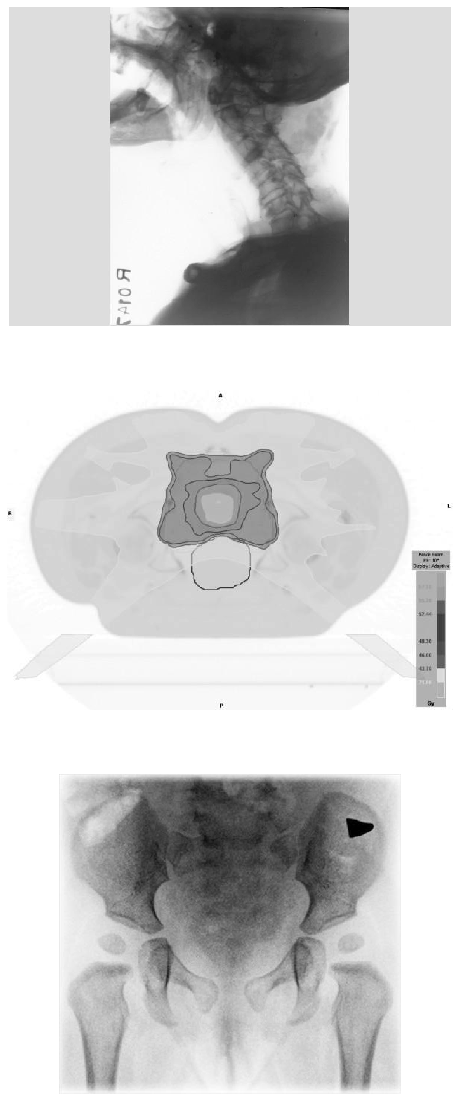

In [6]:
plot_3x_images(train)

## Plotting Images

Now that we have created the necessary functions we can beging plotting our images to better understand our data.

We can see that every radiology image contains some medical abnormalities. Each abnormality is described with a Concept ID (CUI) and corresponds to a UMLS Term.


CUI      |  UMLS Term
C0772294 :  alesion
C0023884 :  gastrointestinal tract
C0221198 :  visible lesion
C0412555 :  obstetric ultrasounds
C0041618 :  medical sonography


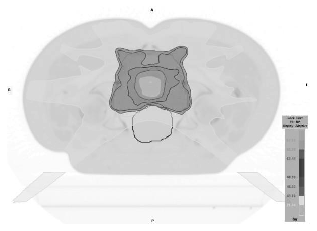

In [7]:
plot_image_with_tags(train[1],train_con.iloc[1, 1])

CUI      |  UMLS Term
C0233492 :  elated
C2985494 :  resorption
C0262950 :  skeleton system
C1306232 :  sever


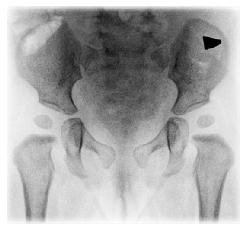

In [8]:
plot_image_with_tags(train[2],train_con.iloc[2, 1])

## Descriptive Statistics

So now that we have understood what our data contains let's try to calculate some statistics that best describe our dataset.

Let's see what we have gathered from our analysis.

* The total number of UMLS Concepts is 5,528
* The total number of UMLS Concepts found in our training images is 5216 so 312 Concepts are not assigned to any training image, something that we will need to keep in mind later
* 1530 concepts were assigned to only one image (which will make more difficult to classify those concepts)
* 4239 Images could be described by just one Concept.
* The average number of Concepts per image is 6
* The maximum number of Concepts in an image is 72

In [9]:
tags = train_con.iloc[:,1]
len(str_con)

5528

In [10]:
tag_dic = create_dic(tags)
len(tag_dic)

5216

In [11]:
len(str_con) - len(tag_dic)

312

In [12]:
tags_df = pd.DataFrame.from_dict(tag_dic, orient='index', columns=['Tag Count'])
tags_df = tags_df.reset_index()
tags_df.rename(columns={'index': 'CUI'}, inplace=True)
tags_df = pd.merge(tags_df, str_con, how='left', on='CUI')
tags_df.sort_values(by=['Tag Count'], ascending=False, inplace=True)
tags_df = tags_df.reset_index()
del tags_df['index']
tags_df[:10]

,CUI,Tag Count,UMLS Term
0,C0441633,6733,diagnostic scanning
1,C0043299,6321,x-ray procedure
2,C1962945,6318,radiogr
3,C0040395,6235,tomogr
4,C0034579,6127,pantomogr
5,C0817096,5981,thoracics
6,C0040405,5801,x-ray computer assisted tomography
7,C1548003,5159,radiograph
8,C0221198,4513,visible lesion
9,C0772294,4512,alesion


In [13]:
len(tags_df.loc[tags_df['Tag Count']==1])

1530

In [14]:
img_dic = {}
for index, row in train_con.iterrows():
    tgs = row['tags'].split(';')
    img_dic[row['image']] = len(tgs)
img_df = pd.DataFrame.from_dict(img_dic, orient='index', columns=['Tag Count'])
img_df = img_df.reset_index()
img_df.rename(columns={'index': 'image'}, inplace=True)
img_df = pd.merge(img_df, train_con, how='left', on='image')
img_df.sort_values(by=['Tag Count'], ascending=False, inplace=True)
img_df = img_df.reset_index()
del img_df['index']
img_df

,image,Tag Count,tags
0,ROCO_CLEF_69357,72,C0544724;C0183191;C0729274;C0565342;C0182362;C...
1,ROCO_CLEF_46672,70,C0544724;C0183191;C0729274;C0565342;C0182362;C...
2,ROCO_CLEF_44813,69,C0922671;C0227991;C0506734;C0582818;C0149575;C...
3,ROCO_CLEF_03622,64,C0150312;C0027121;C2242558;C0038774;C0005558;C...
4,ROCO_CLEF_15228,56,C0746922;C0497156;C3854058;C1514241;C0025519;C...
...,...,...,...
56624,ROCO_CLEF_48497,1,C3282905
56625,ROCO_CLEF_70524,1,C0018494
56626,ROCO_CLEF_52410,1,C0000726
56627,ROCO_CLEF_26633,1,C2700258


In [15]:
img_df['Tag Count'].max()

72

In [16]:
len(img_df.loc[img_df['Tag Count']==1])

4239

In [17]:
img_df['Tag Count'].mean()

6.106871037807484

Let's see the 10 most frequent concepts found in the training set both in a barplot and in a radar plot.

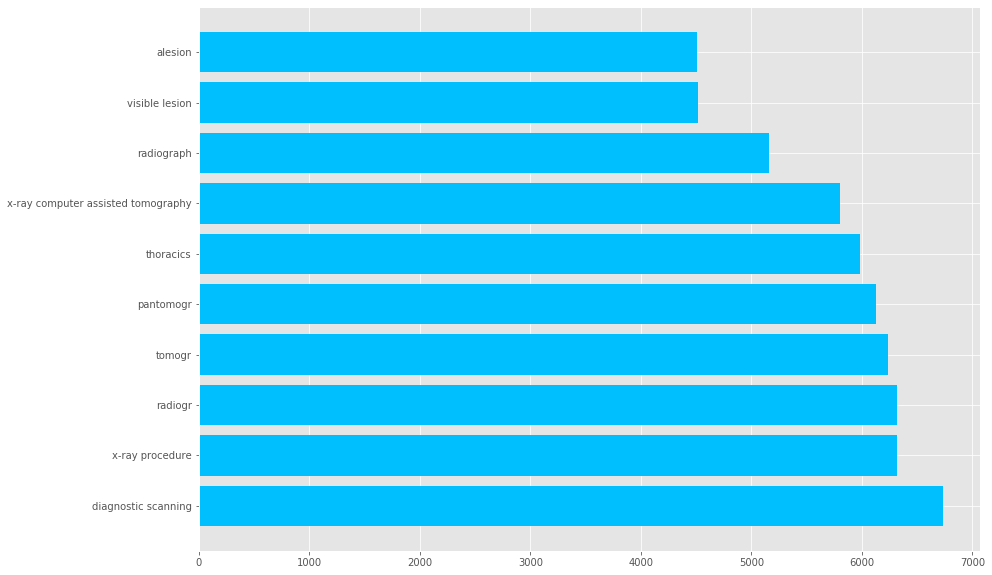

In [18]:
plt.figure(figsize=[14, 10])
plt.barh(tags_df['UMLS Term'][:10], tags_df['Tag Count'][:10], color='deepskyblue')
plt.show()

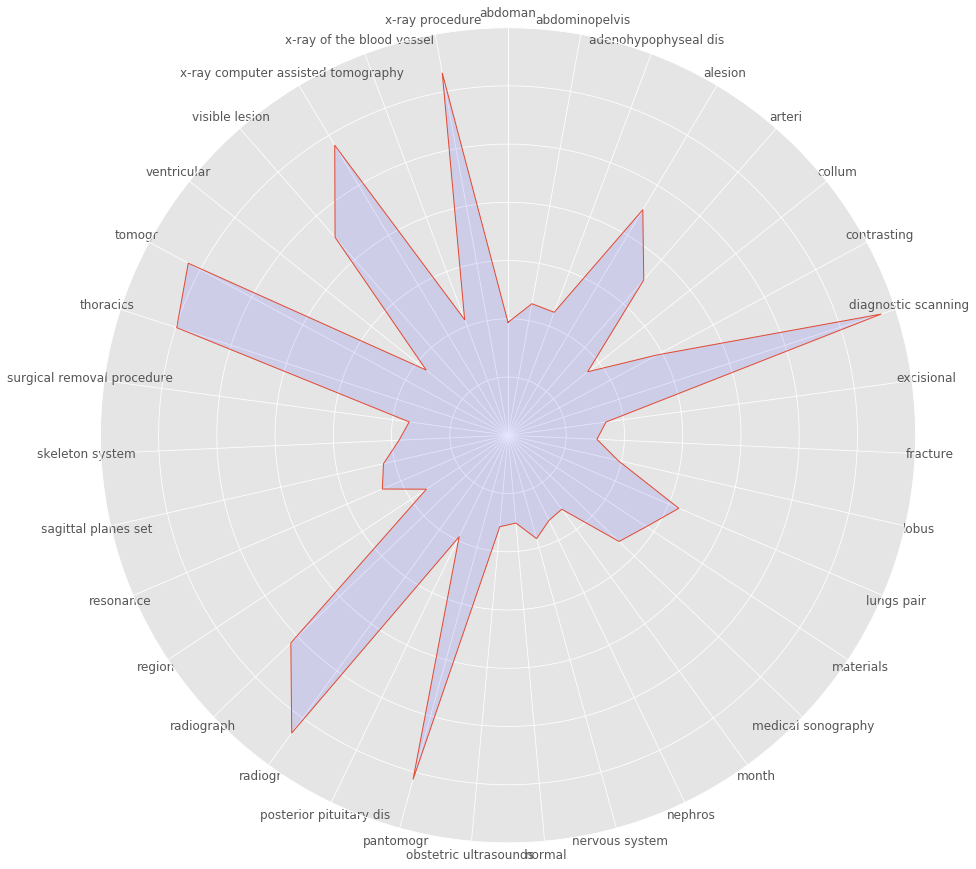

In [19]:
def radar_factory(keys, values, axes=None, fontsize=12):
    
    import math  
    if axes is None:
        plt.figure(figsize=(15, 15))
        ax = plt.subplot(111, polar=True)
    else:
        ax = axes     
    num_categories = len(keys)

    angles = np.arange(num_categories + 1)
    angles = angles / num_categories * 2 * np.pi 
    angles[-1] = angles[0]
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks(angles)
    ax.set_xticklabels(keys)
    ax.set_rlabel_position(0)
    max_y = max(values)
    min_y = min(values)
    values.append(values[0])
    ax.plot(list(angles), values, 
            linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    yticks = ax.get_yticks()
    ax.set_yticklabels([])
    ylims = ax.get_ylim()
    ax.set_ylim(min(yticks[0], ylims[0]), 
                max(yticks[-1], ylims[1]))
x = tags_df.loc[tags_df['Tag Count'] > 1500].copy()
x.sort_values(by=['UMLS Term'], inplace=True)
radar_factory(x['UMLS Term'],list(x['Tag Count']))

# Data Preprocessing

* First, we will need to add the suffix to our image names so that the generator can easily.. generate them.
* Then, we will need to change the way that our tags are written so that we can classify them in a more efficient way. We could use a MultiLabelBinarizer to create binary columns, but I think this will work the same way and it also looks slicker.

In [20]:
train_con['tags']=train_con['tags'].apply(lambda x:x.split(";"))
train_con['image'] = [str(col) + '.jpg' for col in train_con['image']]
train_con

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"
...,...,...
56624,ROCO_CLEF_40405.jpg,"[C0040395, C0034579, C0015450, C0040405]"
56625,ROCO_CLEF_17150.jpg,"[C0286840, C3244287]"
56626,ROCO_CLEF_04341.jpg,"[C0699900, C1553386, C0728863, C0182400, C0042..."
56627,ROCO_CLEF_36569.jpg,"[C0023890, C0441633, C3263723]"


In [21]:
val_con['tags']=val_con['tags'].apply(lambda x:x.split(";"))
val_con['image'] = [str(col) + '.jpg' for col in val_con['image']]
val_con

,image,tags
0,ROCO_CLEF_64017.jpg,"[C0001074, C3203359, C0041618]"
1,ROCO_CLEF_39073.jpg,"[C0027530, C1610719, C0065967, C1704258, C0883..."
2,ROCO_CLEF_18028.jpg,"[C1265876, C1293134, C0029053, C0034579, C0025..."
3,ROCO_CLEF_02052.jpg,"[C0040426, C1962945, C0043299, C0036849, C0150..."
4,ROCO_CLEF_67927.jpg,"[C0184666, C4085643, C4049705, C4049706, C4321..."
...,...,...
14152,ROCO_CLEF_08685.jpg,"[C0043299, C1548003, C1962945]"
14153,ROCO_CLEF_63867.jpg,"[C1963113, C0040395, C0921176, C0034579, C0525..."
14154,ROCO_CLEF_42562.jpg,"[C0456605, C0023884, C0441633]"
14155,ROCO_CLEF_18130.jpg,"[C0009368, C0227391]"


In [22]:
df = pd.concat([train_con, val_con])
df = df.reset_index()
del df['index']
df

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"
...,...,...
70781,ROCO_CLEF_08685.jpg,"[C0043299, C1548003, C1962945]"
70782,ROCO_CLEF_63867.jpg,"[C1963113, C0040395, C0921176, C0034579, C0525..."
70783,ROCO_CLEF_42562.jpg,"[C0456605, C0023884, C0441633]"
70784,ROCO_CLEF_18130.jpg,"[C0009368, C0227391]"


# Build a Baseline

Before we move on to the actualy classification maybe it would be a good idea to build a baseline classifier so that the model that we build is actually better than a simply guessing algorithm

### Most Frequent

The first idea in regards to building the actual baseline classifier is building a classifier that always produces the most frequent labels. We saw that the number 1 label doesn't have much of a difference from the other so maybe the classifier could always produce 3-4 tags.

Let's see how we can accomplish that.

Also, the baseline classifier does not actually need to have access to the images just the dataframes so we can work like that.

In [23]:
base = df.copy()
base

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"
...,...,...
70781,ROCO_CLEF_08685.jpg,"[C0043299, C1548003, C1962945]"
70782,ROCO_CLEF_63867.jpg,"[C1963113, C0040395, C0921176, C0034579, C0525..."
70783,ROCO_CLEF_42562.jpg,"[C0456605, C0023884, C0441633]"
70784,ROCO_CLEF_18130.jpg,"[C0009368, C0227391]"


In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
base = base.join(pd.DataFrame(mlb.fit_transform(base.pop('tags')),
                          columns=mlb.classes_,
                          index=base.index))
base

,image,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,ROCO_CLEF_07350.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ROCO_CLEF_19073.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ROCO_CLEF_60501.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ROCO_CLEF_05564.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ROCO_CLEF_55020.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70781,ROCO_CLEF_08685.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70782,ROCO_CLEF_63867.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70783,ROCO_CLEF_42562.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70784,ROCO_CLEF_18130.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
tags_df[:10]

,CUI,Tag Count,UMLS Term
0,C0441633,6733,diagnostic scanning
1,C0043299,6321,x-ray procedure
2,C1962945,6318,radiogr
3,C0040395,6235,tomogr
4,C0034579,6127,pantomogr
5,C0817096,5981,thoracics
6,C0040405,5801,x-ray computer assisted tomography
7,C1548003,5159,radiograph
8,C0221198,4513,visible lesion
9,C0772294,4512,alesion


In [26]:
base_df = df
base_df

,image,tags
0,ROCO_CLEF_07350.jpg,"[C0203126, C0203051]"
1,ROCO_CLEF_19073.jpg,"[C0772294, C0023884, C0221198, C0412555, C0041..."
2,ROCO_CLEF_60501.jpg,"[C0233492, C2985494, C0262950, C1306232]"
3,ROCO_CLEF_05564.jpg,"[C0521530, C0817096]"
4,ROCO_CLEF_55020.jpg,"[C0935598, C1184743]"
...,...,...
70781,ROCO_CLEF_08685.jpg,"[C0043299, C1548003, C1962945]"
70782,ROCO_CLEF_63867.jpg,"[C1963113, C0040395, C0921176, C0034579, C0525..."
70783,ROCO_CLEF_42562.jpg,"[C0456605, C0023884, C0441633]"
70784,ROCO_CLEF_18130.jpg,"[C0009368, C0227391]"


In [43]:
base_df['tags'] = 'C0441633'
base_df

,image,tags
0,ROCO_CLEF_07350.jpg,C0441633
1,ROCO_CLEF_19073.jpg,C0441633
2,ROCO_CLEF_60501.jpg,C0441633
3,ROCO_CLEF_05564.jpg,C0441633
4,ROCO_CLEF_55020.jpg,C0441633
...,...,...
70781,ROCO_CLEF_08685.jpg,C0441633
70782,ROCO_CLEF_63867.jpg,C0441633
70783,ROCO_CLEF_42562.jpg,C0441633
70784,ROCO_CLEF_18130.jpg,C0441633


In [44]:
X = base_df['image'].copy()
y = base_df.copy()
del y['image']
X_train = X[:56629]
y_train = y[:56629]
X_test = X[56629:70786]
y_test = y[56629:70786]

In [45]:
val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
ground_truth

,image,tags
0,ROCO_CLEF_64017,C0001074;C3203359;C0041618
1,ROCO_CLEF_39073,C0027530;C1610719;C0065967;C1704258;C0883242;C...
2,ROCO_CLEF_18028,C1265876;C1293134;C0029053;C0034579;C0025066;C...
3,ROCO_CLEF_02052,C0040426;C1962945;C0043299;C0036849;C0150312
4,ROCO_CLEF_67927,C0184666;C4085643;C4049705;C4049706;C4321335;C...
...,...,...
14152,ROCO_CLEF_08685,C0043299;C1548003;C1962945
14153,ROCO_CLEF_63867,C1963113;C0040395;C0921176;C0034579;C0525187;C...
14154,ROCO_CLEF_42562,C0456605;C0023884;C0441633
14155,ROCO_CLEF_18130,C0009368;C0227391


In [46]:
y = base_df[56629:70786]
del y['image']
y.reset_index(inplace=True)
del y['index']
val_res = pd.merge(ground_truth.iloc[:, 0], y, left_index=True, right_index=True)
val_res


,image,tags
0,ROCO_CLEF_64017,C0441633
1,ROCO_CLEF_39073,C0441633
2,ROCO_CLEF_18028,C0441633
3,ROCO_CLEF_02052,C0441633
4,ROCO_CLEF_67927,C0441633
...,...,...
14152,ROCO_CLEF_08685,C0441633
14153,ROCO_CLEF_63867,C0441633
14154,ROCO_CLEF_42562,C0441633
14155,ROCO_CLEF_18130,C0441633


In [42]:
val_res.to_csv("base_candidate.csv", sep="\t", index=False, header=False)

ground_truth.to_csv("base_ground_truth.csv", sep="\t", index=False, header=False)

## Baseline Results

So we ran the F1 evaluation code from the competition and we found that the mean score of our baseline is **0.037**. 
So that is the score to beat!
Anything below that can be disregarded.

# Build a Neural Network

Let's start with something simple and work our way to something more complex (and hopefully better).

During our analysis it became clear that we were experiencing some problems with overfitting when we set the steps to generator.n//generator.batch_size as our model was only predicting zeroes.

The other thing that was buffling is that the function predict was not working with the generator and, thus, we had to use predict_generator after reseting first the generator.


## Transfer Learning

The first idea was to use a pre-trained model like the mobilenet developed by Google.

However the results were pretty disappointing and, as a result, the decision was made to start from something simple and more understandable and then move on to something more complex.

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_image_generator.flow_from_dataframe(
dataframe=df[:56629],
directory=train_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(224,224))

valid_generator=validation_image_generator.flow_from_dataframe(
dataframe=df[56629:70786],
directory=val_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(224,224))

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 7s 1us/step


In [14]:
sample_training_images, _ = next(train_generator)

feature_batch = base_model(sample_training_images)
feature_batch.shape

base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape
prediction_layer = keras.layers.Dense(5528, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

TensorShape([Dimension(32), Dimension(5528)])

In [15]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5528)              7081368   
Total params: 9,339,352
Trainable params: 7,081,368
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=10,
                    validation_data=valid_generator,
                    validation_steps=10,
                    epochs=1
)

10/10 [==============================] - 36s 4s/step - loss: 0.5242 - acc: 0.8283 - val_loss: 0.3720 - val_acc: 0.9643


In [18]:
valid_generator.reset()
pred = model.predict_generator(valid_generator,steps=STEP_SIZE_VALID, verbose=1)

442/442 [==============================] - 687s 2s/step


In [19]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pred_df = pd.DataFrame(pred, columns=valid_generator.class_indices)
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0.3053749800,0.2347083092,0.3091251850,0.3216939867,0.3026717305,0.3064099848,0.3016555905,0.2465970516,0.3597706258,0.4385362864,...,0.2595005333,0.2971488237,0.2243930697,0.1506138444,0.1688362658,0.2793288827,0.3577320576,0.2338791788,0.1455062926,0.5923669934
1,0.3211940229,0.2154845297,0.3241849244,0.3608218431,0.2195742726,0.4290339351,0.2607774436,0.2881353498,0.1241041720,0.3422119021,...,0.3581148386,0.4908882678,0.2470420003,0.2540503144,0.1455790699,0.3270390630,0.2753561735,0.2247813642,0.2282931507,0.4372086525
2,0.4192906022,0.1535867453,0.3642010689,0.2189575434,0.4548128843,0.2001069486,0.3161972165,0.3223544359,0.2145453095,0.2803755999,...,0.2831903100,0.4095422029,0.2462424338,0.2731730342,0.3214511275,0.4277007878,0.2364246547,0.1935725212,0.1475194395,0.5060198903
3,0.2031338215,0.2257448435,0.2934144437,0.3659304976,0.3349042833,0.4098349214,0.2603631020,0.3452066779,0.2971883714,0.4103242457,...,0.2943469882,0.4033085406,0.3842630386,0.3677073121,0.2150110304,0.1857018769,0.3413833380,0.3455370963,0.1755385101,0.3311451674
4,0.2266092896,0.1663758457,0.3276596069,0.3606292009,0.4294475913,0.2316427231,0.2012910247,0.2219448388,0.3049694896,0.3436855674,...,0.2524834871,0.4175680578,0.3287826777,0.2266916633,0.1564826667,0.2741448879,0.2924217582,0.2391852736,0.1229573488,0.4008108675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,0.2327974439,0.4769620299,0.3494133949,0.3404944539,0.2502826452,0.2163648009,0.2718883157,0.2446890473,0.2144099474,0.3770983815,...,0.2102725804,0.3679173589,0.2872819901,0.3671607375,0.1951535344,0.2808318734,0.2760902047,0.2752696872,0.2373248935,0.3914711475
14140,0.3523373604,0.2008940578,0.3819141090,0.4031061828,0.2981401086,0.4238029718,0.2694054246,0.3522084653,0.2491376102,0.4884141386,...,0.2533836365,0.5093360543,0.2982900143,0.2807264328,0.2667356133,0.3756861091,0.4131791592,0.3283283114,0.1997019947,0.2915368676
14141,0.2700322866,0.2226551175,0.3080899715,0.3652078509,0.4364103377,0.3590368629,0.3786139488,0.3853965998,0.2801197767,0.3864808977,...,0.2409801185,0.5041933060,0.2556344271,0.3336480856,0.3293963373,0.4934057891,0.3013684452,0.2875896394,0.3126291037,0.6270355582
14142,0.1741445959,0.3951928616,0.2934096158,0.4639093876,0.3625112474,0.2549185157,0.3027372062,0.3452256322,0.3119619489,0.3641815782,...,0.2685327232,0.3660318553,0.1923800111,0.3505173922,0.2281905413,0.3678292036,0.3481015265,0.3566280007,0.2076174021,0.4789768755


In [22]:
df = pred_df>0.4
df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
2,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
3,False,False,False,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14140,False,False,False,True,False,True,False,False,False,True,...,False,True,False,False,False,False,True,False,False,False
14141,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
14142,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [23]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp
res = results
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')

val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
merge_val_res = pd.merge(ground_truth.iloc[:, 0], df_results, left_index=True, right_index=True)
ground_truth_f = pd.merge(ground_truth, merge_val_res.iloc[:, 0], on='image', how='inner')

merge_val_res.to_csv("candidate13.csv", sep="\t", index=False, header=False)

ground_truth_f.to_csv("ground_truth13.csv", sep="\t", index=False, header=False)

Least concepts in set : 1
Most concepts in set : 77
Average concepts in set : 6.141897624434389
Final result
********************************
Obtained score : 30.10703798629894 / 14144
Mean score over all concept sets : 0.0021286084549136694

## Build a Neural Network from scratch

The first attempt included a CNN with 3 convolutional layers and a F1 Mean Score of **0.0524** which is higher than the score of our baseline!

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator=train_image_generator.flow_from_dataframe(
dataframe=df[:56629],
directory=train_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

valid_generator=validation_image_generator.flow_from_dataframe(
dataframe=df[56629:70786],
directory=val_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [9]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same',
                 input_shape=(400,400,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(5528, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 400, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 400, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 198, 32)      4640      
__________________________________________________________

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=10,
                    validation_data=valid_generator,
                    validation_steps=10,
                    epochs=1
)




Epoch 1/1





10/10 [==============================] - 183s 18s/step - loss: 0.0860 - acc: 0.9487 - val_loss: 0.0127 - val_acc: 0.9988


In [11]:
valid_generator.reset()
pred = model.predict_generator(valid_generator,steps=STEP_SIZE_VALID, verbose=1)

442/442 [==============================] - 282s 637ms/step


In [12]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pred_df = pd.DataFrame(pred, columns=valid_generator.class_indices)
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0.0000000000,0.0000000000,0.0000008345,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000298,0.0000001192,0.0000033379,0.0000000894,0.0000000298,0.0000000000,0.0000000596,0.0000001192,0.0000000894,0.0000000596,...,0.0000000596,0.0000000894,0.0000000596,0.0000000298,0.0000000894,0.0000001192,0.0000000000,0.0000000000,0.0000001490,0.0000000596
2,0.0000000298,0.0000000894,0.0000020564,0.0000000000,0.0000000894,0.0000001192,0.0000000894,0.0000000596,0.0000000298,0.0000000894,...,0.0000000894,0.0000000000,0.0000001192,0.0000000000,0.0000000000,0.0000000596,0.0000000298,0.0000000000,0.0000001192,0.0000000894
3,0.0000000000,0.0000000000,0.0000013113,0.0000000000,0.0000000000,0.0000000000,0.0000000894,0.0000000000,0.0000000000,0.0000000596,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000001490,0.0000001192,0.0000059903,0.0000000894,0.0000001788,0.0000001788,0.0000000596,0.0000000000,0.0000001192,0.0000001192,...,0.0000001192,0.0000000596,0.0000001192,0.0000000596,0.0000001192,0.0000000596,0.0000002086,0.0000001192,0.0000001788,0.0000001192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,0.0000000000,0.0000000298,0.0000016093,0.0000000000,0.0000000596,0.0000000894,0.0000000000,0.0000000000,0.0000000894,0.0000000000,...,0.0000000298,0.0000000000,0.0000000298,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000894,0.0000000000
14140,0.0000000000,0.0000000894,0.0000021160,0.0000000298,0.0000001192,0.0000000894,0.0000000894,0.0000000298,0.0000000596,0.0000000298,...,0.0000001192,0.0000000894,0.0000000298,0.0000000000,0.0000000298,0.0000000596,0.0000000894,0.0000000596,0.0000000894,0.0000000894
14141,0.0000159442,0.0000190437,0.0003407300,0.0000178516,0.0000186861,0.0000210404,0.0000207722,0.0000176430,0.0000185966,0.0000234842,...,0.0000203252,0.0000188053,0.0000200868,0.0000182986,0.0000190735,0.0000157952,0.0000180900,0.0000167191,0.0000211000,0.0000193715
14142,0.0000537932,0.0000599027,0.0007318854,0.0000548363,0.0000621080,0.0000666678,0.0000692010,0.0000566840,0.0000615716,0.0000801980,...,0.0000716150,0.0000603795,0.0000661314,0.0000630021,0.0000651777,0.0000507534,0.0000610948,0.0000584126,0.0000670254,0.0000634491


In [13]:
df = pred_df>0.0000021160
df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14140,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14141,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14142,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [15]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp
res = results
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')

val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
merge_val_res = pd.merge(ground_truth.iloc[:, 0], df_results, left_index=True, right_index=True)
ground_truth_f = pd.merge(ground_truth, merge_val_res.iloc[:, 0], on='image', how='inner')

merge_val_res.to_csv("candidate9.csv", sep="\t", index=False, header=False)

ground_truth_f.to_csv("ground_truth9.csv", sep="\t", index=False, header=False)

## Can we improve this CNN?

Oh yes we can! By adding an extra layer we managed to reach a F1 Score **0.076** which is significantly higher than the one of the baseline!

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator=train_image_generator.flow_from_dataframe(
dataframe=df[:56629],
directory=train_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

valid_generator=validation_image_generator.flow_from_dataframe(
dataframe=df[56629:70786],
directory=val_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [32]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same',
                 input_shape=(400,400,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Activation('relu'))
model.add(Dense(5528, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 400, 400, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 400, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 198, 32)      4640      
_________________________________________________________________
activation_2 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 32)        0         
__________

In [11]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=10,
                    validation_data=valid_generator,
                    validation_steps=10,
                    epochs=1
)




Epoch 1/1





10/10 [==============================] - 53s 5s/step - loss: 0.0977 - acc: 0.9485 - val_loss: 0.0153 - val_acc: 0.9987


In [13]:
valid_generator.reset()
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
pred = model.predict_generator(valid_generator,steps=STEP_SIZE_VALID, verbose=1)

442/442 [==============================] - 261s 591ms/step


In [22]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pred_df = pd.DataFrame(pred, columns=valid_generator.class_indices)
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0000000298,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.0000000000,0.0000000000,0.0000000298,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000000000,0.0000000000,0.0000002086,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
14140,0.0000000000,0.0000000000,0.0000001192,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
14141,0.0000000000,0.0000000894,0.0000153780,0.0000000000,0.0000000000,0.0000000000,0.0000000596,0.0000000000,0.0000000000,0.0000000000,...,0.0000000298,0.0000000000,0.0000000298,0.0000000000,0.0000000298,0.0000000298,0.0000000000,0.0000000596,0.0000000000,0.0000000000
14142,0.0000000894,0.0000002086,0.0000509024,0.0000001788,0.0000001788,0.0000002086,0.0000001788,0.0000001192,0.0000002086,0.0000000596,...,0.0000002086,0.0000001788,0.0000001490,0.0000001192,0.0000001490,0.0000001192,0.0000001788,0.0000001490,0.0000001490,0.0000001788


In [23]:
df = pred_df>0.00000001788
df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14140,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14141,False,True,True,False,False,False,True,False,False,False,...,True,False,True,False,True,True,False,True,False,False
14142,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [24]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp


In [25]:
res = results
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')
df_results

,0
0,C0023884;C0024109;C0034579;C0040395;C0040405;C...
1,C0000726;C0009924;C0023884;C0024109;C0034579;C...
2,C0000726;C0009924;C0023884;C0024109;C0034579;C...
3,C0009924;C0024109;C0034579;C0040395;C0040405;C...
4,C0000726;C0003483;C0003842;C0009924;C0023884;C...
...,...
14139,C0009924;C0024109;C0034579;C0040395;C0040405;C...
14140,C0000726;C0009924;C0023884;C0024109;C0034579;C...
14141,C0000723;C0000726;C0000828;C0001209;C0001428;C...
14142,C0000503;C0000723;C0000726;C0000780;C0000782;C...


In [27]:

val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
merge_val_res = pd.merge(ground_truth.iloc[:, 0], df_results, left_index=True, right_index=True)
ground_truth_f = pd.merge(ground_truth, merge_val_res.iloc[:, 0], on='image', how='inner')

merge_val_res.to_csv("candidate5.csv", sep="\t", index=False, header=False)

ground_truth_f.to_csv("ground_truth5.csv", sep="\t", index=False, header=False)

## Can we improve this CNN even more?

And again the answer is yes! By adding another layer we managed to get our F1 Score to **0.0945** which is our highest score yet

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator=train_image_generator.flow_from_dataframe(
dataframe=df[:56629],
directory=train_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

valid_generator=validation_image_generator.flow_from_dataframe(
dataframe=df[56629:70786],
directory=val_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [10]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same',
                 input_shape=(400,400,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Activation('relu'))
model.add(Dense(5528, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 400, 400, 16)      448       
_________________________________________________________________
activation_6 (Activation)    (None, 400, 400, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 198, 198, 32)      4640      
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 99, 32)        0         
__________

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=10,
                    validation_data=valid_generator,
                    validation_steps=10,
                    epochs=1
)




Epoch 1/1





10/10 [==============================] - 37s 4s/step - loss: 0.1139 - acc: 0.9495 - val_loss: 0.0173 - val_acc: 0.9989


In [13]:
valid_generator.reset()
pred = model.predict_generator(valid_generator,steps=STEP_SIZE_VALID, verbose=1)

442/442 [==============================] - 271s 613ms/step


In [15]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)
pred_df = pd.DataFrame(pred, columns=valid_generator.class_indices)
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
1,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
2,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
3,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
4,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14140,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14141,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14142,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000


In [16]:
df = pred_df>0.0
df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14140,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14141,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14142,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp
res = results
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')

val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
merge_val_res = pd.merge(ground_truth.iloc[:, 0], df_results, left_index=True, right_index=True)
ground_truth_f = pd.merge(ground_truth, merge_val_res.iloc[:, 0], on='image', how='inner')

merge_val_res.to_csv("candidate13.csv", sep="\t", index=False, header=False)

ground_truth_f.to_csv("ground_truth13.csv", sep="\t", index=False, header=False)

In [18]:
model.save('best_model2.h5')

## Is is possible to improve our model even more?

Unfortunately, no. Adding another layer did not actually help and dropped our F1 Mean Score to **0.0418**.

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [8]:
train_generator=train_image_generator.flow_from_dataframe(
dataframe=df[:56629],
directory=train_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

valid_generator=validation_image_generator.flow_from_dataframe(
dataframe=df[56629:70786],
directory=val_set,
x_col="image",
y_col="tags",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
classes=names,
target_size=(400,400))

Found 56629 validated image filenames belonging to 5528 classes.
Found 14157 validated image filenames belonging to 5528 classes.


In [10]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same',
                 input_shape=(400,400,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Activation('relu'))
model.add(Dense(5528, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 400, 400, 16)      448       
_________________________________________________________________
activation_7 (Activation)    (None, 400, 400, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 198, 198, 32)      4640      
_________________________________________________________________
activation_8 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
__________

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=10,
                    validation_data=valid_generator,
                    validation_steps=10,
                    epochs=1
)




Epoch 1/1





10/10 [==============================] - 31s 3s/step - loss: 0.1513 - acc: 0.9488 - val_loss: 0.0187 - val_acc: 0.9988


In [13]:
valid_generator.reset()
pred = model.predict_generator(valid_generator,steps=STEP_SIZE_VALID, verbose=1)

442/442 [==============================] - 284s 642ms/step


In [14]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)
pred_df = pd.DataFrame(pred, columns=valid_generator.class_indices)
pred_df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
1,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
2,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
3,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
4,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14140,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14141,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
14142,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,...,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000


In [15]:
df = pred_df>0.0
df

,C0000503,C0000723,C0000726,C0000780,C0000782,C0000790,C0000828,C0000925,C0000934,C0000962,...,C4330491,C4331246,C4331837,C4476838,C4479170,C4479578,C4505257,C4505346,C4505362,C4505478
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14140,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14141,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14142,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp
res = results
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')

val_concepts = 'ImageCLEF2019/val_concepts.csv'
ground_truth = pd.read_csv(val_concepts)
merge_val_res = pd.merge(ground_truth.iloc[:, 0], df_results, left_index=True, right_index=True)
ground_truth_f = pd.merge(ground_truth, merge_val_res.iloc[:, 0], on='image', how='inner')

merge_val_res.to_csv("candidate13.csv", sep="\t", index=False, header=False)

ground_truth_f.to_csv("ground_truth13.csv", sep="\t", index=False, header=False)

## Final Results

Apart from the results presented in this notebook several more networks and models were developed, but were somewhat unsuccessful.

The best model achieved 0.094 F1 Mean score and we will be using that for our test images.

In [24]:
from tensorflow.keras.models import load_model

model = load_model('best_model2.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 400, 400, 16)      448       
_________________________________________________________________
activation_6 (Activation)    (None, 400, 400, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 200, 200, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 198, 198, 32)      4640      
_________________________________________________________________
activation_

In [25]:
test_set = 'ImageCLEF2019/test/'
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(batch_size=32,
                              directory=test_set,
                              class_mode=None,
                             #classes=names,
                             target_size=(400, 400),
                             shuffle=False)

Found 10000 images belonging to 1 classes.


In [26]:
pred = model.predict(test_generator, verbose=1)

313/313 [==============================] - 189s 604ms/step


In [27]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pred_df = pd.DataFrame(pred, columns=names)
pred_df

,C0032143,C0225516,C0825429,C0020461,C0947912,C0700164,C0935912,C0334467,C0334460,C0040578,...,C0567198,C0553702,C0028945,C1510755,C3151530,C0044955,C3812869,C2751430,C0441621,C0237886
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
9996,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
9997,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
9998,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [28]:
df = pred_df>0.0
df

,C0032143,C0225516,C0825429,C0020461,C0947912,C0700164,C0935912,C0334467,C0334460,C0040578,...,C0567198,C0553702,C0028945,C1510755,C3151530,C0044955,C3812869,C2751430,C0441621,C0237886
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
import os
test_set = 'ImageCLEF2019/test/test-set'
x = os.listdir(test_set)
name_df = pd.DataFrame(x, columns=['image'])
name_df = name_df.applymap(lambda x: str(x).rstrip('.jpg'))
name_df

,image
0,ROCO_CLEF_TEST_00001
1,ROCO_CLEF_TEST_00002
2,ROCO_CLEF_TEST_00003
3,ROCO_CLEF_TEST_00004
4,ROCO_CLEF_TEST_00005
...,...
9995,ROCO_CLEF_TEST_09996
9996,ROCO_CLEF_TEST_09997
9997,ROCO_CLEF_TEST_09998
9998,ROCO_CLEF_TEST_09999


In [30]:
df.insert(loc=0, column='image', value=name_df['image'])
df

,image,C0032143,C0225516,C0825429,C0020461,C0947912,C0700164,C0935912,C0334467,C0334460,...,C0567198,C0553702,C0028945,C1510755,C3151530,C0044955,C3812869,C2751430,C0441621,C0237886
0,ROCO_CLEF_TEST_00001,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,ROCO_CLEF_TEST_00002,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,ROCO_CLEF_TEST_00003,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,ROCO_CLEF_TEST_00004,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,ROCO_CLEF_TEST_00005,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ROCO_CLEF_TEST_09996,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,ROCO_CLEF_TEST_09997,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,ROCO_CLEF_TEST_09998,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,ROCO_CLEF_TEST_09999,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
results = {}
for i, row in df.iterrows():
    temp = []
    for j, col in enumerate(df):
        if df.iloc[i, j] == True:
            temp.append(col)
    results[i] = temp
res = results


In [32]:
res

{0: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 1: ['C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 2: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 3: ['C0449878',
  'C0184913',
  'C1548806',
  'C0796494',
  'C0031845',
  'C0456171',
  'C1321013'],
 4: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 5: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 6: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 7: ['C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 8: ['C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 9: ['C0449878', 'C0184913', 'C1548806', 'C0796494', 'C0031845', 'C1321013'],
 10: ['C0449878',
  'C0184913',
  'C1548806',
  'C0152344',
  'C0796494',
  'C0019066',
  'C0031845',
  'C4329495',
  'C0456171',
  'C1321013'],
 11: ['C0449878',
  'C0184913',
  'C1548806',
  'C0152344',
  'C0796494',
  'C0019066',

In [33]:
for key in results:
    res[key] = ";".join(res[key])
df_results = pd.DataFrame.from_dict(res, orient='index')

df_results

,0
0,C0449878;C0184913;C1548806;C0796494;C0031845;C...
1,C0184913;C1548806;C0796494;C0031845;C1321013
2,C0449878;C0184913;C1548806;C0796494;C0031845;C...
3,C0449878;C0184913;C1548806;C0796494;C0031845;C...
4,C0449878;C0184913;C1548806;C0796494;C0031845;C...
...,...
9995,C0184913;C1548806;C0796494;C0031845;C1321013
9996,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9997,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9998,C0449878;C0184913;C1548806;C0796494;C0031845;C...


In [34]:
test_pred = pd.merge(df.iloc[:, 0], df_results, left_index=True, right_index=True)
test_pred


,image,0
0,ROCO_CLEF_TEST_00001,C0449878;C0184913;C1548806;C0796494;C0031845;C...
1,ROCO_CLEF_TEST_00002,C0184913;C1548806;C0796494;C0031845;C1321013
2,ROCO_CLEF_TEST_00003,C0449878;C0184913;C1548806;C0796494;C0031845;C...
3,ROCO_CLEF_TEST_00004,C0449878;C0184913;C1548806;C0796494;C0031845;C...
4,ROCO_CLEF_TEST_00005,C0449878;C0184913;C1548806;C0796494;C0031845;C...
...,...,...
9995,ROCO_CLEF_TEST_09996,C0184913;C1548806;C0796494;C0031845;C1321013
9996,ROCO_CLEF_TEST_09997,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9997,ROCO_CLEF_TEST_09998,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9998,ROCO_CLEF_TEST_09999,C0449878;C0184913;C1548806;C0796494;C0031845;C...


In [39]:
test_pred.rename(columns={0:'tags'}, inplace=True)
test_pred

,image,tags
0,ROCO_CLEF_TEST_00001,C0449878;C0184913;C1548806;C0796494;C0031845;C...
1,ROCO_CLEF_TEST_00002,C0184913;C1548806;C0796494;C0031845;C1321013
2,ROCO_CLEF_TEST_00003,C0449878;C0184913;C1548806;C0796494;C0031845;C...
3,ROCO_CLEF_TEST_00004,C0449878;C0184913;C1548806;C0796494;C0031845;C...
4,ROCO_CLEF_TEST_00005,C0449878;C0184913;C1548806;C0796494;C0031845;C...
...,...,...
9995,ROCO_CLEF_TEST_09996,C0184913;C1548806;C0796494;C0031845;C1321013
9996,ROCO_CLEF_TEST_09997,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9997,ROCO_CLEF_TEST_09998,C0449878;C0184913;C1548806;C0796494;C0031845;C...
9998,ROCO_CLEF_TEST_09999,C0449878;C0184913;C1548806;C0796494;C0031845;C...


In [40]:
test_pred.to_csv("Babetas_8160078_test.csv", sep="\t", index=False, header=False)

As we can see our model predicts a lot of concepts in every image but hopefully that will not decrease our F1 Score by  a lot.